Dataset siap diproses dengan 1000 baris dan 17 kolom.
Jumlah data duplikat: 0
Tidak ada missing values dalam dataset.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16800\747957537.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16800\747957537.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



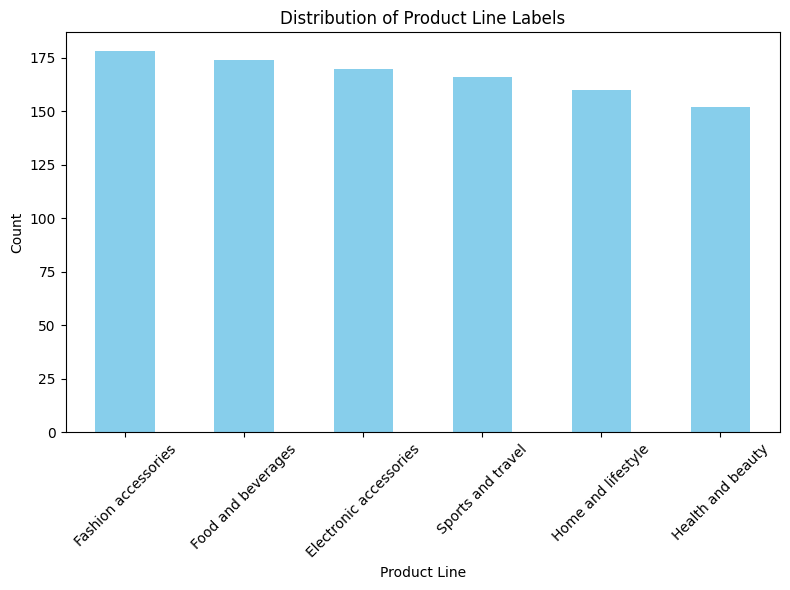

Sample data:
    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715 2019-01-05   
1  Electronic accessories       15.28         5   3.8200   80.2200 2019-03-08   
2      Home and lifestyle       46.33         7  16.2155  340.5255 2019-03-03   
3       Health and beauty       58.22         8  23.2880  489.0480 2019-01-27   
4       Sports and travel       86.31         7  30.2085  634.3785 2019-02-08   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  \
0  13:08      Ewallet  522.83                 4.761905       26.1415   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16800\747957537.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_month_data['Predicted_Quantity'] = np.ceil(future_quantity_predictions)  # Membulatkan prediksi ke atas
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16800\747957537.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_month_data['Recommended_Quantity'] = np.ceil(next_month_data['Predicted_Quantity'] * 1.1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16800\747957537.py:138: UserWarning: se

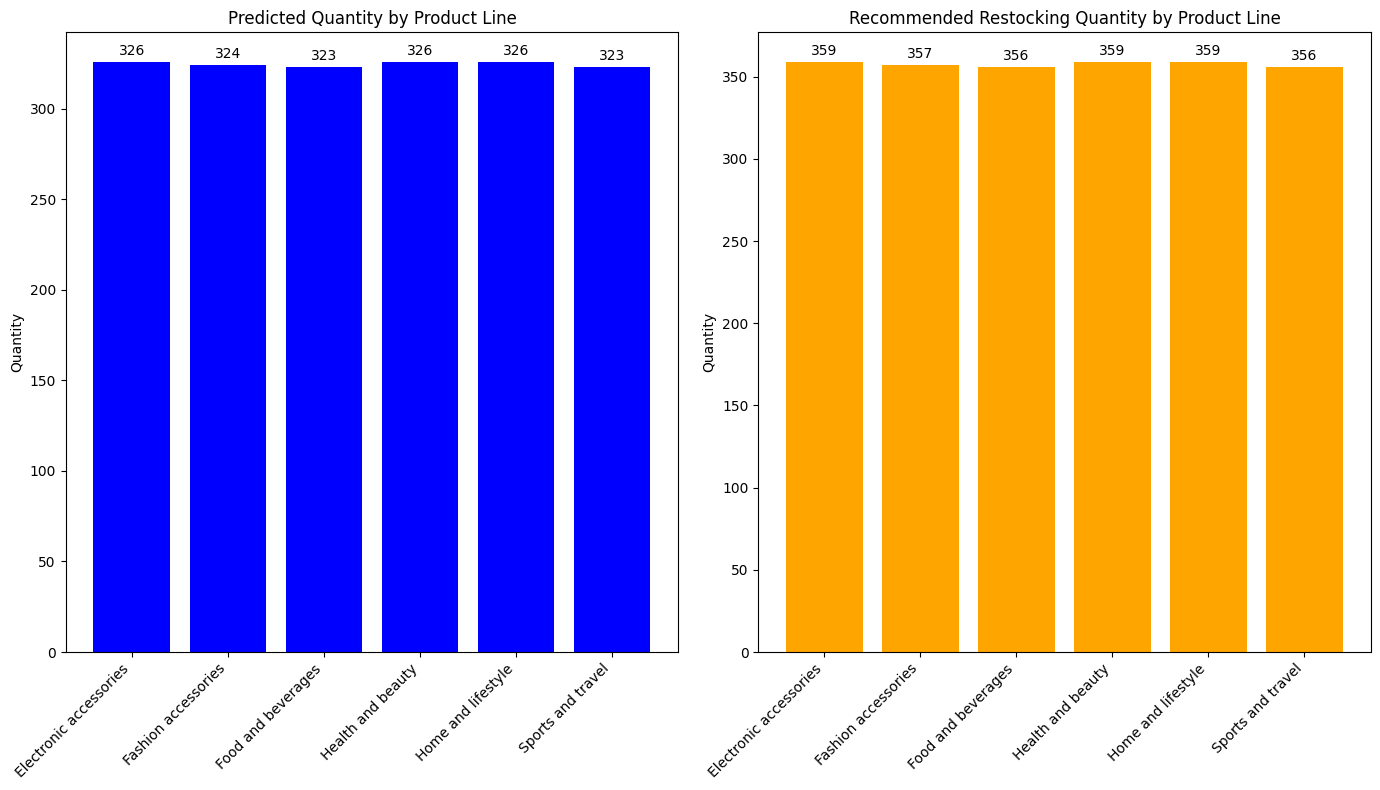

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Memuat dataset dari file CSV
file_path = '../dataset/supermarket_sales - Sheet1.csv'
data = pd.read_csv(file_path)

# Cek dataset kosong
if data.empty:
    print("Dataset kosong, tidak ada data untuk diproses.")
else:
    print(f"Dataset siap diproses dengan {data.shape[0]} baris dan {data.shape[1]} kolom.")

# Tangani missing value untuk data numerik dan kategorikal
for column in data.columns:
    if data[column].dtype == 'object':  # Kolom non-numerik
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Kolom numerik
        data[column].fillna(data[column].mean(), inplace=True)

# Cek jumlah baris duplikat
duplicate_rows = data[data.duplicated()]
print(f"Jumlah data duplikat: {duplicate_rows.shape[0]}")

# Cek kembali missing value
missing_values = data.isnull().sum().sum()
if missing_values > 0:
    print(f"Ada {missing_values} missing values yang perlu ditangani.")
else:
    print("Tidak ada missing values dalam dataset.")

# Label encoding untuk 'Product line'
data['Product_Label'] = data['Product line'].astype('category').cat.codes

# Tampilkan grafik distribusi label
plt.figure(figsize=(8, 6))
data['Product line'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Product Line Labels')
plt.xlabel('Product Line')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mengonversi kolom 'Date' ke format datetime untuk mempermudah manipulasi data waktu
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Tangani tanggal invalid
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    
# Mengelompokkan data berdasarkan Product line dan Month untuk merangkum total jumlah barang dan rata-rata harga per unit
monthly_sales = data.groupby(['Product line', 'Month']).agg(
    Total_Quantity=('Quantity', 'sum'),
    Average_Unit_Price=('Unit price', 'mean')
).reset_index()

# Menampilkan data keseluruhan (5 baris pertama)
print("Sample data:")
print(data.head())

# Menampilkan data atribut yang digunakan dan jumlah kelas
print("Attributes used for training:", ['Month', 'Total_Quantity', 'Average_Unit_Price'])
print("Number of classes in Product_Label:", data['Product_Label'].nunique())

# Menyiapkan variabel fitur (X) dan target (y)
X = monthly_sales[['Month', 'Total_Quantity', 'Average_Unit_Price']]
y = monthly_sales['Total_Quantity']

# Melakukan normalisasi data menggunakan StandardScaler untuk meningkatkan performa model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Membagi data menjadi data latih (training) dan data uji (testing) dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Melatih model Support Vector Regression (SVR) dengan data latih
svm_model = SVR()
svm_model.fit(X_train, y_train)

# Prediksi dan evaluasi menggunakan RMSE
y_pred = svm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Menghitung akurasi model menggunakan fungsi yang mengukur selisih antara prediksi dan nilai aktual
def accuracy(y_test, y_pred):
    return 1 - np.sqrt(np.mean((y_test - y_pred) ** 2)) / np.mean(y_test)

# Menghitung akurasi model SVM
svm_accuracy = accuracy(y_test, y_pred)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

# Menentukan bulan berikutnya berdasarkan data terakhir
next_month = monthly_sales['Month'].max() + 1 if monthly_sales['Month'].max() < 12 else 1
next_month_data = monthly_sales[monthly_sales['Month'] == (next_month - 1 if next_month > 1 else 12)]
X_future = next_month_data[['Month', 'Total_Quantity', 'Average_Unit_Price']]

# Menyiapkan data fitur untuk prediksi bulan berikutnya
X_future_scaled = scaler.transform(X_future)
future_quantity_predictions = svm_model.predict(X_future_scaled)

# Melakukan prediksi jumlah barang terjual untuk bulan berikutnya
next_month_data['Predicted_Quantity'] = np.ceil(future_quantity_predictions)  # Membulatkan prediksi ke atas

# Menambahkan kolom untuk rekomendasi stok (10% lebih banyak dari prediksi)
next_month_data['Recommended_Quantity'] = np.ceil(next_month_data['Predicted_Quantity'] * 1.1)

# Data untuk visualisasi: prediksi kuantitas dan rekomendasi stok berdasarkan lini produk
visualization_data = next_month_data[['Product line', 'Predicted_Quantity', 'Recommended_Quantity']]

# Simpan hasil prediksi dan rekomendasi ke file CSV
output_file_path = '../result/svm/predictions_and_recommendations_svm.csv'  # Ganti dengan path yang diinginkan
visualization_data.to_csv(output_file_path, index=False)
print(f"Hasil prediksi dan rekomendasi disimpan di {output_file_path}")

# Simpan RMSE dan akurasi ke file CSV
metrics = {
    'RMSE': [rmse],
    'Accuracy (%)': [svm_accuracy * 100]
}
metrics_df = pd.DataFrame(metrics)
metrics_file_path = '../result/svm/model_metrics_svm.csv'  # Ganti dengan path yang diinginkan
metrics_df.to_csv(metrics_file_path, index=False)
print(f"Metrik evaluasi disimpan di {metrics_file_path}")

# Membuat subplots untuk visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Diagram batang untuk jumlah prediksi berdasarkan lini produk
rects1 = ax1.bar(visualization_data['Product line'], visualization_data['Predicted_Quantity'], color='blue')
ax1.set_ylabel('Quantity')
ax1.set_title('Predicted Quantity by Product Line')
ax1.set_xticklabels(visualization_data['Product line'], rotation=45, ha='right')

# Menambahkan label pada setiap batang diagram (jumlah prediksi)
for rect in rects1:
    height = rect.get_height()
    ax1.annotate(f'{int(height)}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # Offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Diagram batang untuk rekomendasi stok berdasarkan lini produk
rects2 = ax2.bar(visualization_data['Product line'], visualization_data['Recommended_Quantity'], color='orange')
ax2.set_ylabel('Quantity')
ax2.set_title('Recommended Restocking Quantity by Product Line')
ax2.set_xticklabels(visualization_data['Product line'], rotation=45, ha='right')

# Menambahkan label pada setiap batang diagram (jumlah rekomendasi)
for rect in rects2:
    height = rect.get_height()
    ax2.annotate(f'{int(height)}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # Offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Mengatur tata letak agar tidak bertumpuk
plt.tight_layout()
plt.show()